In [2]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#stats
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import pyLDAvis

#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords

#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm, ensemble,decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split,GridSearchCV

import  textblob
from xgboost import XGBClassifier

from textblob import TextBlob
from nltk.stem import PorterStemmer
import nltk
from textblob import Word
from imblearn.over_sampling import RandomOverSampler

#settings
color = sns.color_palette()
sns.set_style("dark")

lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

%matplotlib inline

In [3]:
bank_reviews = pd.read_excel('BankReviews.xlsx')

In [4]:
bank_reviews.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [5]:
bank_reviews = bank_reviews[['Stars','Reviews']]

In [6]:
df = bank_reviews

In [7]:
#Exploratory data analysis

df['Reviews'] = df['Reviews'].astype(str)
df['count_sent']=df["Reviews"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
df['count_word']=df["Reviews"].apply(lambda x: len(str(x).split()))

#Unique word count
df['count_unique_word']=df["Reviews"].apply(lambda x: len(set(str(x).split())))

#Letter count
df['count_letters']=df["Reviews"].apply(lambda x: len(str(x)))

#Word density

df['word_density'] = df['count_letters'] / (df['count_word']+1)

#punctuation count
df["count_punctuations"] =df["Reviews"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
df["count_words_upper"] = df["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#upper case words count
df["count_words_lower"] = df["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))

#title case words count
df["count_words_title"] = df["Reviews"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Average length of the words
df["mean_word_len"] = df["Reviews"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Number of numeric
df['numeric'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isdigit()]))

#Number of alphanumeric
df['alphanumeric'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalnum()]))

#Number of alphabetics
df['alphabetetics'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isalpha()]))

#Number of alphabetics
df['Spaces'] = df['Reviews'].apply(lambda x :len([x for x in x.split() if x.isspace()]))

#Number of Words ends with
df['words_ends_with_et'] = df['Reviews'].apply(lambda x :len([x for x in x.lower().split() if x.endswith('et')]))

#Number of Words ends with
df['words_start_with_no'] = df['Reviews'].apply(lambda x :len([x for x in x.lower().split() if x.startswith('no')]))

# Count the occurences of all words
df['wordcounts'] = df['Reviews'].apply(lambda x :dict([ [t, x.split().count(t)] for t in set(x.split()) ]))

In [8]:
df.head()

,Stars,Reviews,count_sent,count_word,count_unique_word,count_letters,word_density,count_punctuations,count_words_upper,count_words_lower,count_words_title,mean_word_len,numeric,alphanumeric,alphabetetics,Spaces,words_ends_with_et,words_start_with_no,wordcounts
0,5,"Great job, Wyndham Capital! Each person was pr...",1,19,19,126,6.300000,4,0,14,5,5.684211,0,15,15,0,0,0,"{'and': 1, 'our': 1, 'Wyndham': 1, 'you!': 1, ..."
1,5,Matthew Richardson is professional and helpful...,1,25,23,159,6.115385,4,0,20,5,5.400000,0,21,21,0,0,0,"{'and': 1, 'mortgage.': 1, 'our': 1, 'Matthew!..."
2,5,We had a past experience with Wyndham Mortgage...,1,79,64,462,5.775000,8,0,64,14,4.860759,0,73,73,0,0,1,"{'&': 1, 'and': 4, 'on': 1, 'We': 2, 'found': ..."
3,5,We have been dealing with Brad Thomka from the...,1,108,78,605,5.550459,9,0,88,18,4.611111,0,101,101,0,0,1,"{'on': 1, 'of': 1, 'found': 1, 'team': 2, 'mil..."
4,5,I can't express how grateful I am for the supp...,1,59,47,341,5.683333,6,3,50,9,4.796610,0,53,53,0,0,1,"{'and': 4, 'purchase!': 1, 'way.': 1, 'home': ..."


## Sentiment Analysis

In [9]:
df['Sentiment'] = df["Reviews"].apply(lambda x: TextBlob(x).sentiment.polarity)

In [10]:
df  = df[['Stars','Reviews','Sentiment']]

In [11]:
df['sentiment_cat'] = np.where(df.Sentiment > 0,'Positive', np.where(df.Sentiment == 0,'Neutral','Negative'))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
df.head()

,Stars,Reviews,Sentiment,sentiment_cat
0,5,"Great job, Wyndham Capital! Each person was pr...",0.533333,Positive
1,5,Matthew Richardson is professional and helpful...,0.453333,Positive
2,5,We had a past experience with Wyndham Mortgage...,-0.033231,Negative
3,5,We have been dealing with Brad Thomka from the...,0.093740,Positive
4,5,I can't express how grateful I am for the supp...,0.125000,Positive


In [13]:
#Splitting data
X = df.Reviews
y = df.Stars

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

In [14]:
#UDF to clean the text
import string
stop = set(nltk.corpus.stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)   
    return(text)

In [15]:
def pre_process(text):
    text = text.str.replace('/','')                          
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in stop))
    text = text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return(text)

In [16]:
X_train = X_train.apply(lambda x: clean_text(x))
X_test = X_test.apply(lambda x: clean_text(x))

In [17]:
X_train = pre_process(X_train)
X_test = pre_process(X_test)

In [18]:
#Making a copy of X train and test for Topic modelling
lda_Train = X_train 
lda_Test = X_test

In [19]:
#Creating a frequency DTM
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' ,
                             max_features=800)
xtrain_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

In [20]:
X_train_TM = xtrain_count 
X_test_TM = X_test_count

In [21]:
dtm = pd.DataFrame(xtrain_count.toarray())

In [22]:
#Adding columns to DTM
dtm.columns = count_vect.get_feature_names()

In [23]:
dtm.head()

,aaron,able,absolutely,accept,accommodating,account,accurate,across,adam,adan,...,work,worked,working,worth,would,wouldnt,wrong,wyndham,year,yet
0,0,1,0,1,0,0,0,1,0,0,...,3,0,1,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


## Word Cloud and Bar Graph

In [24]:
word_freq = pd.DataFrame(dtm.apply(sum).head(20), columns=['freq'])
word_freq.sort_values('freq', ascending=False, inplace=True)

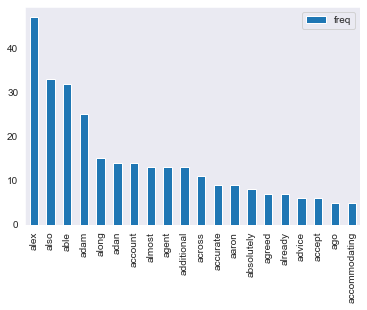

In [25]:
word_freq.plot(kind='bar')

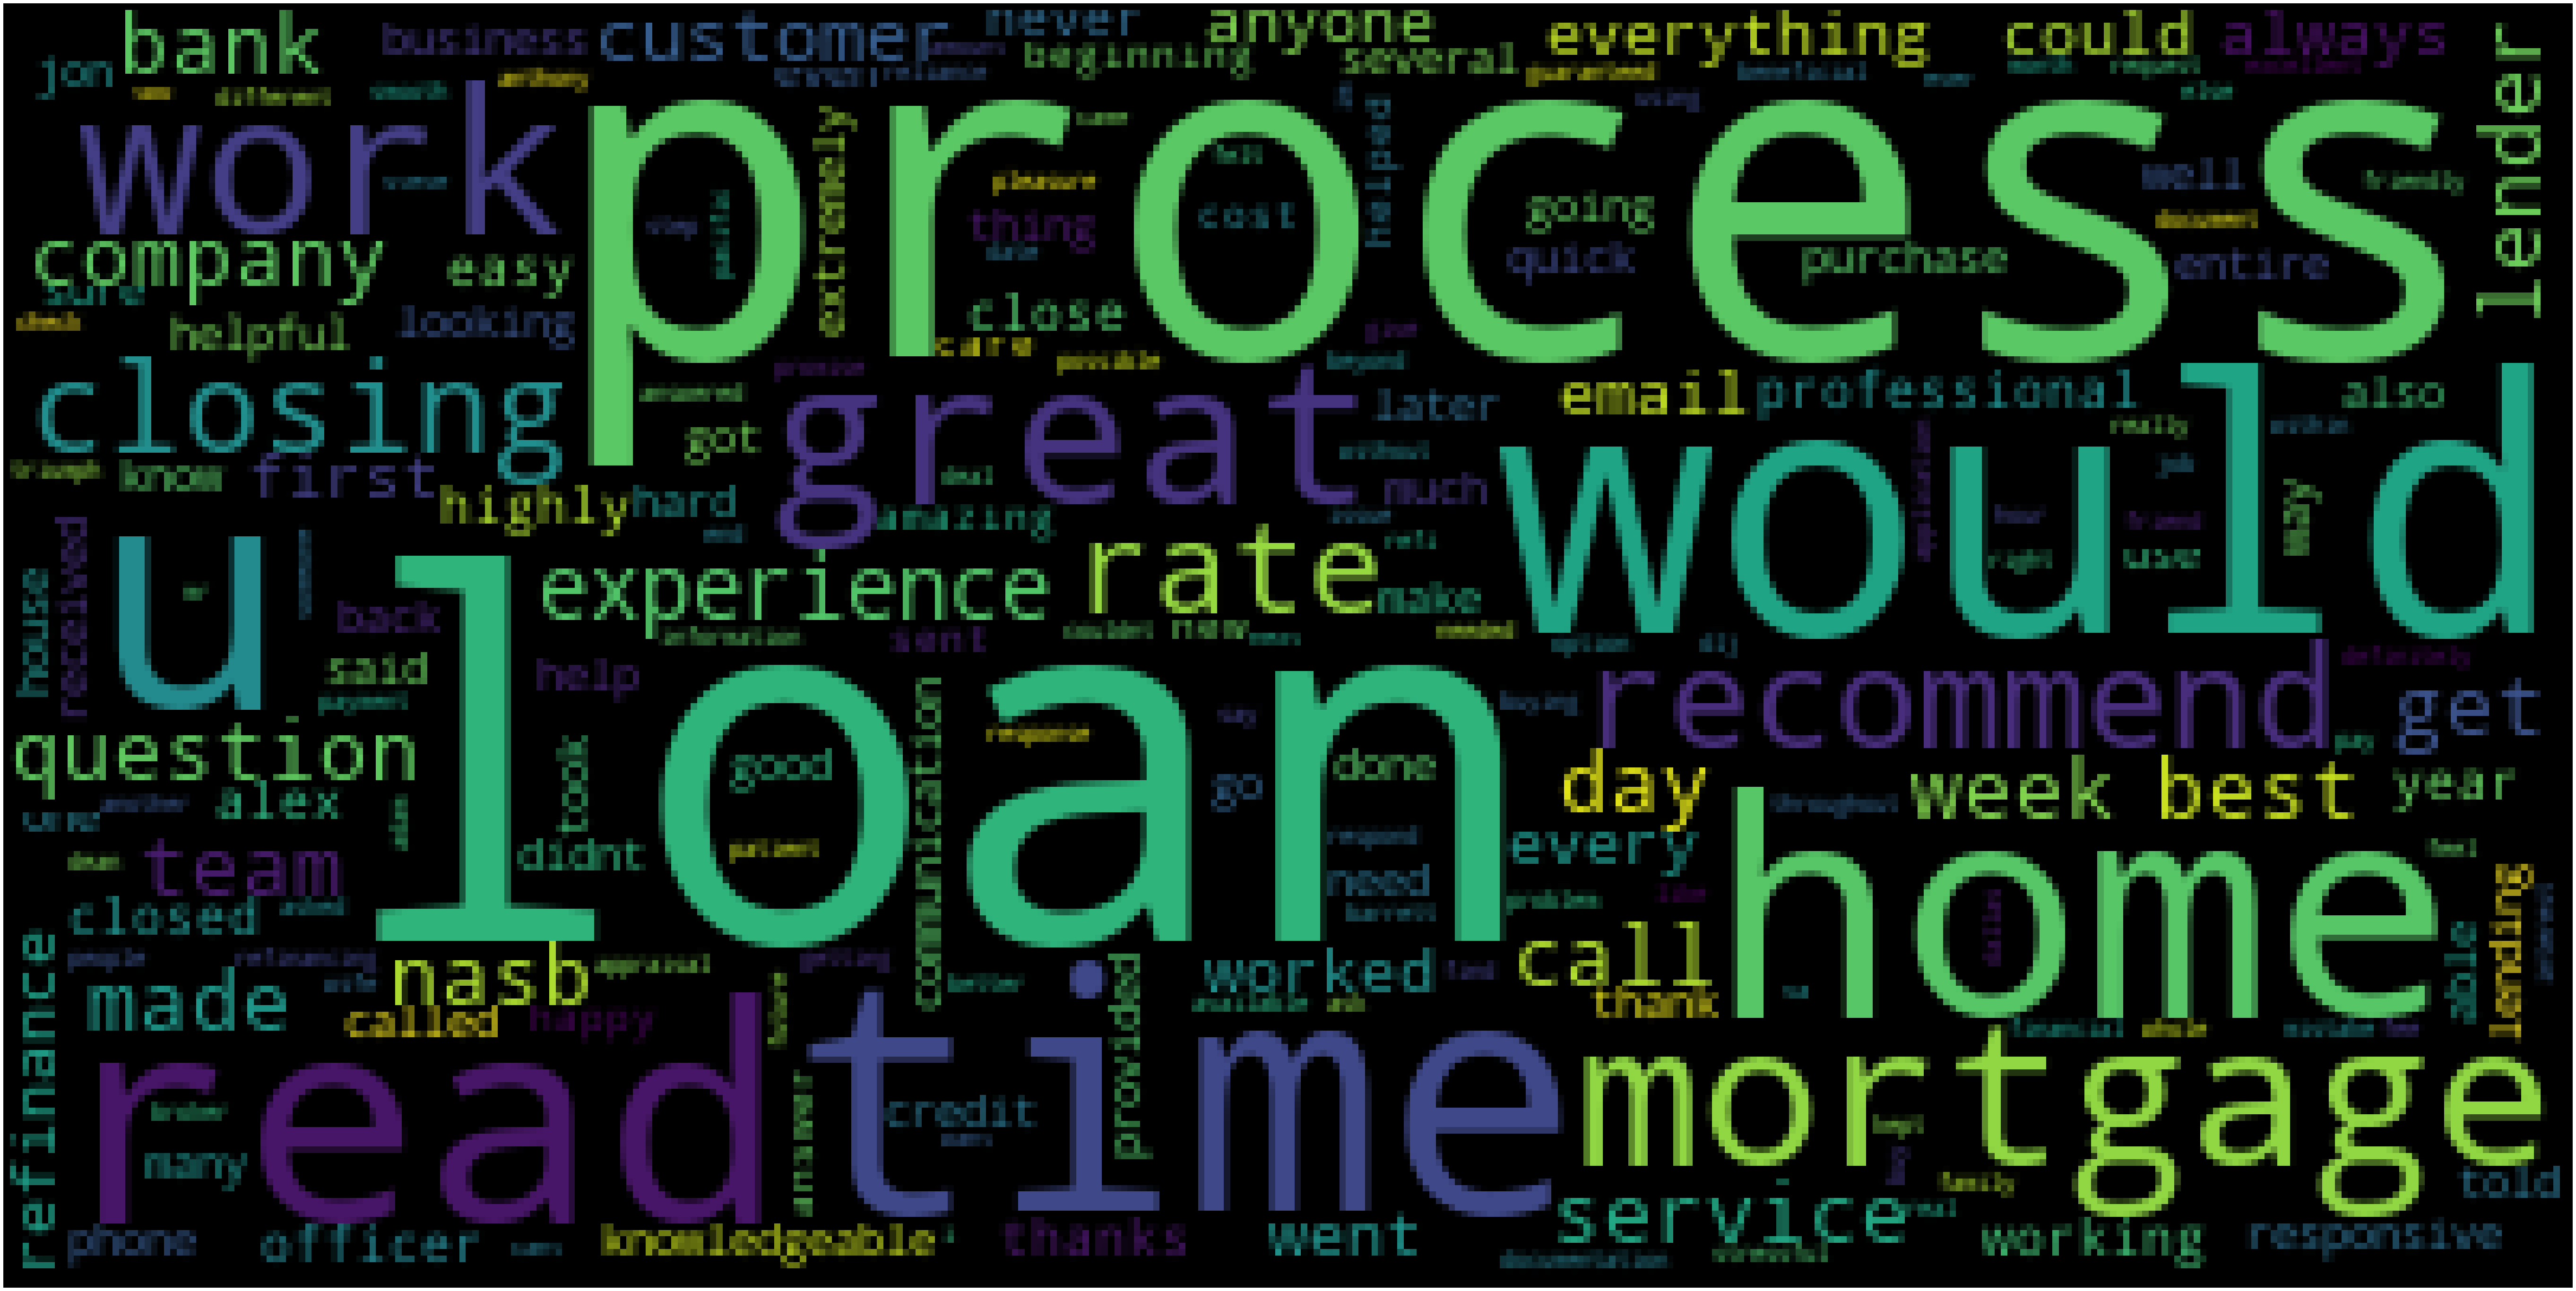

In [26]:
#Generating word clouds
word_freq = dict(dtm.apply(sum))
wordcloud = WordCloud(background_color='black', stopwords=stop)

wordcloud = wordcloud.generate_from_frequencies(word_freq)
fig = plt.figure(1, figsize=(200, 50))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

## Classification

In [27]:
#Checking if the y variable is balanced
np.unique(y_train,return_counts=True)

(array([1, 5], dtype=int64), array([ 70, 308], dtype=int64))

In [28]:
#Checking if the y variable is balanced
np.unique(y_test,return_counts=True)

(array([1, 5], dtype=int64), array([ 25, 102], dtype=int64))

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(378,)
(127,)
(378,)
(127,)


In [30]:
#Creating a frequency DTM
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', 
                             ngram_range=(1, 1 ), 
                             min_df=5, 
                             encoding='latin-1' ,
                             max_features=800)
xtrain_count = count_vect.fit_transform(X_train)
X_test_count = count_vect.transform(X_test)

## We need to perform over or under sampling to make the variable balanced. In this case, i went with over sampling of the lower class.

In [31]:
#Handling imbalance data for train
random_sample = RandomOverSampler(random_state = 111)
X_train,y_train = random_sample.fit_sample(xtrain_count,y_train)

In [32]:
np.unique(y_train,return_counts=True)

(array([1, 5], dtype=int64), array([308, 308], dtype=int64))

In [33]:
#Handling imbalance data for test
random_sample = RandomOverSampler(random_state = 1137)
X_test,y_test = random_sample.fit_sample(X_test_count,y_test)

In [34]:
np.unique(y_test,return_counts=True)

(array([1, 5], dtype=int64), array([102, 102], dtype=int64))

In [35]:
#Classification using Logistic Regression
logistic_reg = LogisticRegression()
logistic_reg.fit(X_train, y_train)

LogisticRegression()

In [36]:
#Accuracy on train data
logistic_reg.score(X_train, y_train)

0.9983766233766234

In [37]:
#Predictions on test data
y_pred_class = logistic_reg.predict(X_test)
print('Accuracy using Logistic Regression is',metrics.accuracy_score(y_test, y_pred_class))

Accuracy using Logistic Regression is 0.9068627450980392


In [38]:
#Good ness of fit metrics based on categorical predicted output for train & test
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           1       0.99      0.82      0.90       102
           5       0.85      0.99      0.91       102

    accuracy                           0.91       204
   macro avg       0.92      0.91      0.91       204
weighted avg       0.92      0.91      0.91       204



Text(0.5, 16.0, 'Predicted Class')

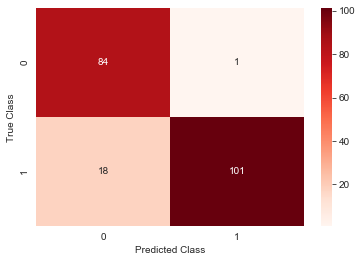

In [41]:
#Confusion matrix
final_cm = metrics.confusion_matrix(y_pred_class,y_test)
sns.heatmap(final_cm,annot = True, cmap = 'Reds',fmt = 'd')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [42]:
#using XGB Classifier
#param_grid = {'n_estimators': [200,300,400,600],'learning_rate' : [0.01,0.04,0.07,0.09,1]}
#xgb_model = GridSearchCV(XGBClassifier(), param_grid, cv = 11, n_jobs = -1,verbose = 1, scoring='accuracy')
#xgb_model.fit(X_train, y_train)

In [43]:
#Classification using XGB Classifier
xgb_estimator = XGBClassifier(n_estimators=400,
                         random_state = 1137,
                        n_jobs=-1,learning_rate = 0.5)
xgb_estimator.fit(X_train, y_train)

XGBClassifier(learning_rate=0.5, n_estimators=400, n_jobs=-1, random_state=1137)

In [44]:
#Accuracy on train data
xgb_estimator.score(X_train, y_train)

0.9983766233766234

In [45]:
#Predicting on test data
y_pred_class = xgb_estimator.predict(X_test)
print('Accuracy using XGB Classifier is',metrics.accuracy_score(y_test, y_pred_class))

Accuracy using XGB Classifier is 0.803921568627451


In [46]:
#Good ness of fit metrics based on categorical predicted output for train & test
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           1       0.93      0.66      0.77       102
           5       0.73      0.95      0.83       102

    accuracy                           0.80       204
   macro avg       0.83      0.80      0.80       204
weighted avg       0.83      0.80      0.80       204



Text(0.5, 16.0, 'Predicted Class')

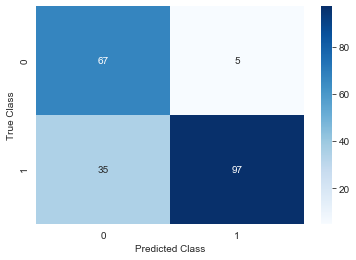

In [48]:
#Confusion matrix
final_cm = metrics.confusion_matrix(y_pred_class,y_test)
sns.heatmap(final_cm,annot = True, cmap = 'Blues',fmt = 'd')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [49]:
#Classification using RF Classifier and gridsearch
param_grid = {'max_depth': [5,6,7,8,9,10], 'n_estimators':[50,100,200,300,400,500,700], 'max_features':[4,5,6,7,8]}
RF_GCV_model = GridSearchCV(ensemble.RandomForestClassifier(), param_grid, cv = 10,n_jobs = -1)
RF_GCV_model = RF_GCV_model.fit(X_train, y_train)

In [50]:
RF_GCV_model.best_params_

{'max_depth': 10, 'max_features': 7, 'n_estimators': 400}

In [55]:
rf_all_estimator = ensemble.RandomForestClassifier(n_estimators = 400,
                                          random_state = 42,
                                          max_depth = 10,
                                          max_features = 7,
                                          n_jobs = -1)
rf_all_estimator = rf_all_estimator.fit(X_train, y_train)

In [56]:
#Accuracy on train data
rf_all_estimator.score(X_train, y_train)

0.961038961038961

In [57]:
#Predicting on test data
y_pred_class = rf_all_estimator.predict(X_test)
print('Accuracy using RF Classifier is',metrics.accuracy_score(y_test, y_pred_class))

Accuracy using RF Classifier is 0.8137254901960784


In [58]:
#Good ness of fit metrics based on categorical predicted output for train & test
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           1       0.97      0.65      0.78       102
           5       0.74      0.98      0.84       102

    accuracy                           0.81       204
   macro avg       0.85      0.81      0.81       204
weighted avg       0.85      0.81      0.81       204



Text(0.5, 16.0, 'Predicted Class')

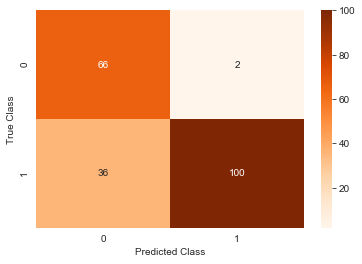

In [60]:
#Confusion matrix
final_cm = metrics.confusion_matrix(y_pred_class,y_test)
sns.heatmap(final_cm,annot = True, cmap = 'Oranges',fmt = 'd')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [61]:
#Classification using Naive Bayes
nb_clf = naive_bayes.MultinomialNB()
nb_clf.fit(X_train, y_train)

MultinomialNB()

In [62]:
#Accuracy on train data
nb_clf.score(X_train, y_train)

0.9707792207792207

In [63]:
#Predicting on test data
y_pred_class = nb_clf.predict(X_test)
print('Accuracy using Naive Bayes Classifier is',metrics.accuracy_score(y_test, y_pred_class))

Accuracy using Naive Bayes Classifier is 0.9362745098039216


In [64]:
#Good ness of fit metrics based on categorical predicted output for train & test
print(metrics.classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           1       0.97      0.90      0.93       102
           5       0.91      0.97      0.94       102

    accuracy                           0.94       204
   macro avg       0.94      0.94      0.94       204
weighted avg       0.94      0.94      0.94       204



Text(0.5, 16.0, 'Predicted Class')

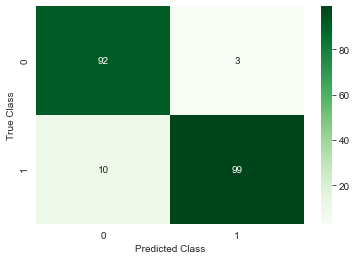

In [66]:
#Confusion matrix
final_cm = metrics.confusion_matrix(y_pred_class,y_test)
sns.heatmap(final_cm,annot = True, cmap = 'Greens',fmt = 'd')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

## Of all the above built classification models, Naive bayesian classification model gave me the best accuracy on the on test data of 93.6% and on train data it gave me 97% accuracy.So i would go ahead with naive bayes model for further classification  in the future.

# Topic Modeling 

In [70]:
#Importing Gensim
import gensim
from gensim import corpora

In [73]:
X_train_tokens = [doc.split() for doc in lda_Train]

In [74]:
dictionary = corpora.Dictionary(X_train_tokens)

In [75]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in X_train_tokens]

In [76]:
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

In [77]:
# Running and Training LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics = 11, id2word = dictionary, passes = 1)

In [ ]:
#print(ldamodel.print_topics(num_topics = 5, num_words = 10))

In [ ]:
#for i in range(0,11):
    #print('Topic',i)
    #print(ldamodel.print_topic(i))

In [78]:
topics = ldamodel.show_topics(formatted = False, num_words = 100)

#for t in range(len(topics)):
    #print("\nTopic {}, top {} words:".format(t,100))
    #print(" ".join([w[0] for w in topics[t][1]]))

In [79]:
#Build LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components = 20, max_iter = 10, learning_decay = 0.9,
                                                    learning_method = 'online', random_state = 1137,
                                                    batch_size = 128, evaluate_every = -1, n_jobs = -1)
lda_model.fit_transform(X_train_TM)

array([[3.16455697e-04, 3.16455697e-04, 3.16455699e-04, ...,
        3.16455698e-04, 3.16455697e-04, 3.16455698e-04],
       [3.33333336e-03, 3.33333334e-03, 3.33333334e-03, ...,
        3.33333334e-03, 3.33333339e-03, 3.33333335e-03],
       [2.77777778e-03, 2.77777778e-03, 2.77777780e-03, ...,
        2.77777778e-03, 2.77777778e-03, 2.77777779e-03],
       ...,
       [9.44117647e-01, 2.94117647e-03, 2.94117648e-03, ...,
        2.94117647e-03, 2.94117647e-03, 2.94117648e-03],
       [2.77777780e-03, 2.77777778e-03, 2.77777779e-03, ...,
        2.77777779e-03, 2.77777785e-03, 2.77777782e-03],
       [2.17391305e-03, 2.17391305e-03, 2.17391307e-03, ...,
        2.17391310e-03, 2.17391305e-03, 2.17391305e-03]])

In [80]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(X_train_TM))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(X_train_TM))

Log Likelihood:  -76274.12448044417
Perplexity:  861.1731865534172


In [81]:
lda_model.n_components = 20

In [83]:
#Create Document - Topic Matrix
lda_output = lda_model.transform(X_train_TM)

#Column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

#Index names
docnames = ["Doc" + str(i) for i in range(len(lda_Train))]

#Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns = topicnames, index = docnames)

#Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis = 1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.29,0.0,0.70,0.0,0.0,0.0,16
Doc1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.94,0.0,0.0,0.0,16
Doc2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.95,0.0,0.0,0.0,16
Doc3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.97,0.0,0.0,0.0,16
Doc4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.97,0.0,0.00,0.0,0.0,0.0,14


In [85]:
#Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

#Assign Column and Index
df_topic_keywords.columns = count_vect.get_feature_names()
df_topic_keywords.index = topicnames

#View
df_topic_keywords.head()

,aaron,able,absolutely,accept,accommodating,account,accurate,across,adam,adan,...,work,worked,working,worth,would,wouldnt,wrong,wyndham,year,yet
Topic0,0.182371,0.198427,0.191606,0.202684,0.191768,0.202994,0.160577,0.213932,0.208693,0.229791,...,0.218327,0.352746,0.344991,0.202561,0.368195,0.230558,0.195979,0.185459,0.252032,0.284046
Topic1,0.216877,0.196290,0.198745,0.192233,0.185881,0.183365,0.178117,0.178382,0.185769,0.208979,...,0.403791,0.243481,0.207704,0.213907,0.258020,0.189020,0.188540,0.177474,0.183019,0.188610
Topic2,0.223686,0.164763,0.264527,0.202526,0.184957,0.226166,0.209711,0.188648,0.212903,0.188426,...,0.224318,0.199102,0.200479,1.043680,0.598839,0.203957,0.184202,0.186725,0.243140,0.178859
Topic3,0.189317,0.267141,0.202013,0.209124,0.159938,0.197817,0.182719,0.196373,0.191110,0.216693,...,0.329059,0.248046,0.245399,0.219284,0.193887,0.182475,0.196864,0.182511,0.186289,0.162811
Topic4,0.187579,1.590778,0.182946,0.181535,0.184594,0.224003,0.169084,0.211976,0.211863,0.188222,...,0.192799,2.758187,0.209847,0.218151,0.340821,0.173642,0.208193,0.183685,0.204708,0.187336


In [86]:
# Show top n keywords for each topic
def show_topics(vectorizer = count_vect, lda_model = lda_model, n_words = 20):
    keywords = np.array(count_vect.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer = count_vect, lda_model = lda_model, n_words = 11)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 0,anthony,oriented,process,entire,team,dlj,mortgage,knowledgeable,financial,go,looking
Topic 1,bank,real,great,people,pleasure,walk,talk,business,fine,time,work
Topic 2,nasb,service,satisfied,dallas,tree,lending,closing,time,mortgage,product,cost
Topic 3,honest,responsive,jason,june,work,person,loan,great,helpful,close,jon
Topic 4,kory,throughout,thanks,process,informative,entire,moving,complicated,calm,none,forward
Topic 5,loan,time,mistake,would,officer,cant,refinance,best,experience,company,without
Topic 6,barrett,mr,top,client,professionally,nasb,experience,beyond,even,really,truly
Topic 7,responsive,work,guy,good,surprise,delay,due,several,company,recommend,would
Topic 8,poor,dallas,u,contacted,communication,process,loan,werent,nasb,house,sure
Topic 9,closing,check,day,could,bob,id,told,send,sent,le,paperwork
